 **NMC-LCO 18650 Battrery -- Nominal capacity of 2.8 Ah**


#Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
# from catboost import CatBoostRegressor

In [4]:
df=pd.read_csv('Battery_RUL.csv')
x = df.iloc[:,:-1]
y=df.iloc[:,-1]

In [5]:
df.shape

(15064, 9)

In [6]:
df.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [7]:
df.tail()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1
15063,1112.0,677537.27,142740.640000,4.206,3.305,49680.004,599830.14,599830.14,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [9]:
df.isnull().sum()

Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64

In [10]:
df.isnull().sum()/df.shape[0]*100 #persentage of null values

Cycle_Index                  0.0
Discharge Time (s)           0.0
Decrement 3.6-3.4V (s)       0.0
Max. Voltage Dischar. (V)    0.0
Min. Voltage Charg. (V)      0.0
Time at 4.15V (s)            0.0
Time constant current (s)    0.0
Charging time (s)            0.0
RUL                          0.0
dtype: float64

In [11]:
df.duplicated().sum() #finding duplicates

np.int64(0)

In [12]:
#finding garbage values
for i in df.select_dtypes(include='int64').columns:
  print(df[i].value_counts())
  print("***"*10)

RUL
0       14
1       14
2       14
3       14
1080    14
        ..
1133     1
1125     1
1119     1
1118     1
1120     1
Name: count, Length: 1133, dtype: int64
******************************



**Exploratory data analysis**

In [13]:
#descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cycle_Index,15064.0,556.155005,322.378480,1.000,271.000000,560.000000,833.0000,1134.000
Discharge Time (s),15064.0,4581.273960,33144.012077,8.690,1169.310000,1557.250000,1908.0000,958320.370
Decrement 3.6-3.4V (s),15064.0,1239.784672,15039.589269,-397645.908,319.600000,439.239471,600.0000,406703.768
Max. Voltage Dischar. (V),15064.0,3.908176,0.091003,3.043,3.846000,3.906000,3.9720,4.363
Min. Voltage Charg. (V),15064.0,3.577904,0.123695,3.022,3.488000,3.574000,3.6630,4.379
Time at 4.15V (s),15064.0,3768.336171,9129.552477,-113.584,1828.884179,2930.203500,4088.3265,245101.117
Time constant current (s),15064.0,5461.266970,25155.845202,5.980,2564.310000,3824.260000,5012.3500,880728.100
Charging time (s),15064.0,10066.496204,26415.354121,5.980,7841.922500,8320.415000,8763.2825,880728.100
RUL,15064.0,554.194172,322.434514,0.000,277.000000,551.000000,839.0000,1133.000


**Data Visualization**

**Outlier Detection Using Box Plot**

In [14]:
df.select_dtypes(include='number').columns

Index(['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL'],
      dtype='object')

**Detecting the Correlations between Features to Features**

In [15]:
#correlation with heatmap to interpret the ralation and mlticollinearity
s=df.corr()
s

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
Cycle_Index,1.000000,-0.011925,-0.012090,-0.782859,0.759850,-0.176486,-0.040622,-0.018305,-0.999756
Discharge Time (s),-0.011925,1.000000,0.444984,0.349161,-0.239410,0.776720,0.912536,0.935544,0.011957
Decrement 3.6-3.4V (s),-0.012090,0.444984,1.000000,0.199470,-0.132765,0.477091,0.343228,0.371610,0.011998
Max. Voltage Dischar. (V),-0.782859,0.349161,0.199470,1.000000,-0.718182,0.446070,0.286886,0.269009,0.782800
Min. Voltage Charg. (V),0.759850,-0.239410,-0.132765,-0.718182,1.000000,-0.344098,-0.216840,-0.200423,-0.759805
Time at 4.15V (s),-0.176486,0.776720,0.477091,0.446070,-0.344098,1.000000,0.568922,0.676859,0.176514
Time constant current (s),-0.040622,0.912536,0.343228,0.286886,-0.216840,0.568922,1.000000,0.953522,0.040675
Charging time (s),-0.018305,0.935544,0.371610,0.269009,-0.200423,0.676859,0.953522,1.000000,0.018299
RUL,-0.999756,0.011957,0.011998,0.782800,-0.759805,0.176514,0.040675,0.018299,1.000000


**Heat Map for correlation**

<Axes: >

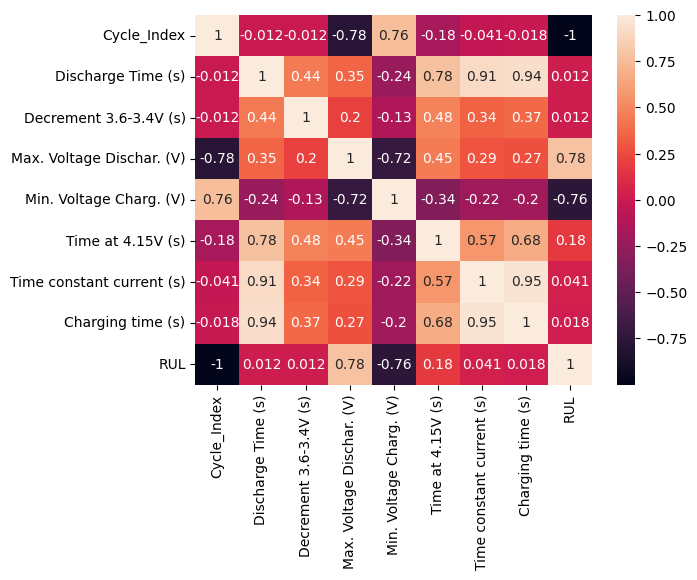

In [16]:
sns.heatmap(s,annot=True)

**Outliers Treatment**

In [17]:
#decide whether tomdo outliers treatment or not, if d how?
#we should do outliers treatment for only for the continous numerical data but
# but bot chatagerical data or target variabe or discrete variable

In [18]:
df.columns

Index(['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL'],
      dtype='object')

In [19]:
def range(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1
  lr=q1-1.5*iqr
  ur=q3+1.5*iqr
  return lr,ur

In [20]:
range(df['Time at 4.15V (s)'])

(np.float64(-1560.279303574469), np.float64(7477.489982145373))

In [21]:
for i in ['Time at 4.15V (s)','Time constant current (s)','Discharge Time (s)','Decrement 3.6-3.4V (s)','Charging time (s)']:
  lr,ur=range(df[i])
  df[i]=np.where(df[i]<lr,lr,df[i])
  df[i]=np.where(df[i]>ur,ur,df[i])

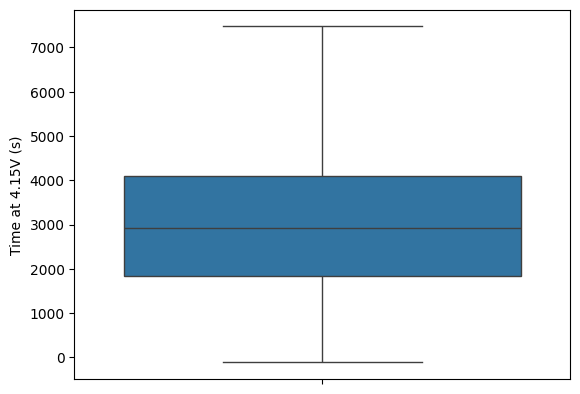

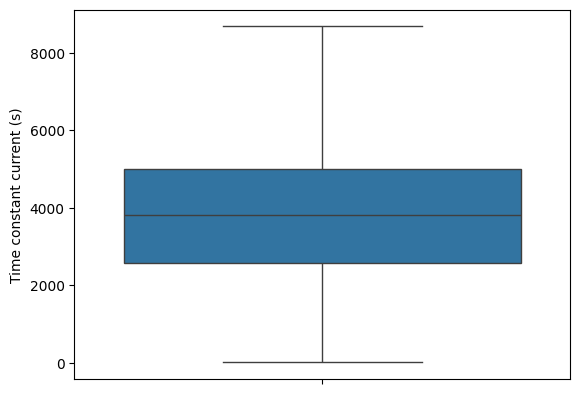

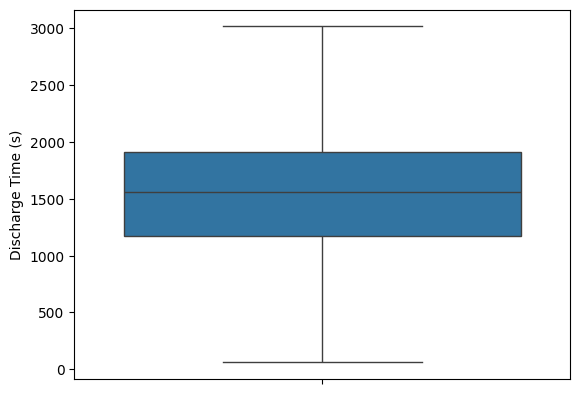

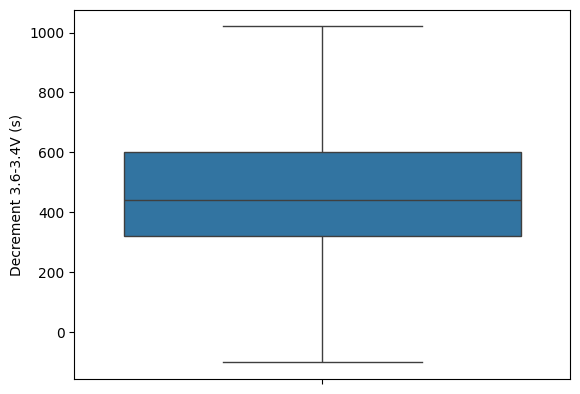

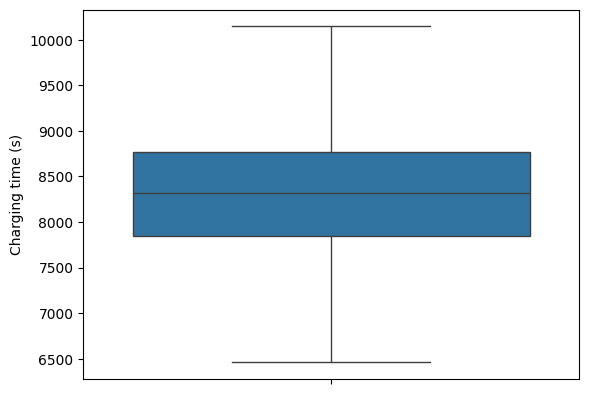

In [22]:
for i in ['Time at 4.15V (s)','Time constant current (s)','Discharge Time (s)','Decrement 3.6-3.4V (s)','Charging time (s)']:
  sns.boxplot(df[i])
  plt.show()

**SPLITTING DATA INTO TRAINING AND TEST SET**

In [23]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [24]:
def error_cal(y_test,y_predicted_test):



  mae_test=mean_absolute_error(y_test,y_predicted_test)
  mse_test=mean_squared_error(y_test,y_predicted_test)
  rmse_test=np.sqrt(mean_squared_error(y_test,y_predicted_test))
  r2_test=r2_score(y_test,y_predicted_test)

  return mae_test,mse_test,rmse_test,r2_test

#Linear Regression Model

In [25]:
model=LinearRegression()
model.fit(x_train,y_train)

y_predicted_test=model.predict(x_test)

In [26]:
mae_test,mse_test,rmse_test,r2_test=error_cal(y_test,y_predicted_test)
result=[]

result.append({'model':'Linear Regression',
               'mae_test':mae_test,
               'mse_test':mse_test,
               'rmse_test':rmse_test,
                'R2_Score':r2_test

})
result_lr=pd.DataFrame(result)
result_lr

,model,mae_test,mse_test,rmse_test,R2_Score
0,Linear Regression,4.425304,48.91736,6.994095,0.999536


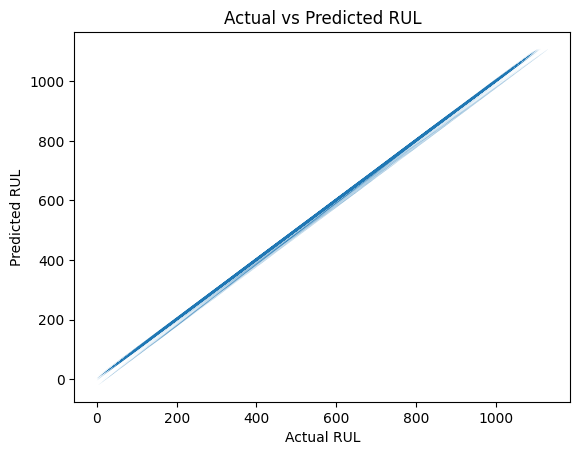

In [27]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_predicted_test,linewidth=0.01)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL")
plt.show()


**For Selected Features**

In [28]:
x_selected = x.iloc[:, [0, 3, 4]]
from sklearn.model_selection import train_test_split
x_train_sel,x_test_sel,y_train_sel,y_test_sel=train_test_split(x_selected,y,test_size=0.2,random_state=1)

In [29]:
model2=LinearRegression()
model2.fit(x_train_sel, y_train_sel)
y_sel_predicted_test=model2.predict(x_test_sel)

In [30]:
mae_test_sel,mse_test_sel,rmse_test_sel,r2_test_sel=error_cal(y_test_sel,y_sel_predicted_test)
result2=[]

result2.append({'model':'Linear Regression Selected',
               'mae_test':mae_test_sel,
               'mse_test':mse_test_sel,
               'rmse_test':rmse_test_sel,
                'R2_Score':r2_test_sel

})
result_lr2=pd.DataFrame(result2)
display(result_lr2)

,model,mae_test,mse_test,rmse_test,R2_Score
0,Linear Regression Selected,4.423015,48.907618,6.993398,0.999536


**Finding prediction for first row for all features**

In [31]:
c = model.intercept_
slopes = model.coef_

X = df.values[:,:-1]



prediction = np.dot(X,slopes) + c

print("Intercept:", c)

print("Prediction:", prediction[0])


Intercept: 1108.3945017542853
Prediction: 1109.071573808892


****Finding prediction for first row for only selected features****

In [32]:
c = model.intercept_
slopes = model.coef_

X = df.values[:,:-1]

selected_indices = [0, 3, 4]

selected_features = X[:,selected_indices]
selected_slopes = slopes[selected_indices]

prediction = np.dot(selected_features, (selected_slopes)) + c

print("Intercept:", c)

print("Prediction:", prediction[0])


Intercept: 1108.3945017542853
Prediction: 1109.0026797753867


#Random Forest Regressor Model

In [33]:
# from sklearn.ensemble import RandomForestRegressor
# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
# grid_rf.fit(x_train, y_train)
# rf_model = grid_rf.best_estimator_  
# rf_y_predicted_test=rf_model.predict(x_test)

In [34]:
# mae_rf,mse_rf,rmse_rf,r2_rf=error_cal(y_test,rf_y_predicted_test)

# result3=[]

# result3.append({'model':'Random Forest',
#                'mae_test':mae_rf,
#                'mse_test':mse_rf,
#                'rmse_test':rmse_rf,
#                 'R2_Score':r2_rf

# })
# result_rf=pd.DataFrame(result3)
# result_rf

In [35]:
# plt.plot(y_test,y_predicted_test)
# plt.xlabel('RUL')
# plt.ylabel('Predicted RUL')
# plt.title('RUL vs Predicted RUL')
# plt.show()

**For Selected Features**

In [36]:
# # Define the parameter grid
# param_grid_rf2 = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf2, cv=3, scoring='r2', n_jobs=-1)
# grid_rf.fit(x_train_sel, y_train_sel)
# rf_model2 = grid_rf.best_estimator_
# y_sel_predicted_test2 = rf_model2.predict(x_test_sel)

In [37]:
# mae_test_sel2,mse_test_sel2,rmse_test_sel2,r2_test_sel2=error_cal(y_test_sel,y_sel_predicted_test2)
# result4=[]

# result4.append({'model':'Random Forest Selected',
#                'mae_test':mae_test_sel2,
#                'mse_test':mse_test_sel2,
#                'rmse_test':rmse_test_sel2,
#                 'R2_Score':r2_test_sel2

# })
# result_rf2=pd.DataFrame(result4)
# result_rf2

#Support Vector Regression

#XG-Boost

In [38]:
# from xgboost import XGBRegressor
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10]
# }
# grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
# grid_xgb.fit(x_train, y_train)
# xgb_model = grid_xgb.best_estimator_ 
# y_pred_xgb=xgb_model.predict(x_test)

In [39]:
# mae_xg,mse_xg,rmse_xg,r2_score_xg=error_cal(y_test,y_pred_xgb)
# result7=[]
# result7.append({'model':'XG Boost',
#                'mae_test':mae_xg,
#                'mse_test':mse_xg,
#                'rmse_test':rmse_xg,
#                 'R2_Score':r2_score_xg

# })
# xg_result1=pd.DataFrame(result7)
# xg_result1

**For Selected Features**

In [40]:
# param_grid_xgb2 = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10],
#     'subsample': [0.7, 1.0],
#     'colsample_bytree': [0.7, 1.0]
# }
# grid_xgb = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), 
#                          param_grid_xgb2, cv=3, scoring='r2', n_jobs=-1)
# grid_xgb.fit(x_train_sel, y_train_sel)
# xgb_model2 = grid_xgb.best_estimator_
# y_pred_xgb_sel = xgb_model2.predict(x_test_sel)

In [41]:
# mae_xg2,mse_xg2,rmse_xg2,r2_score_xg2=error_cal(y_test,y_pred_xgb_sel)
# result8=[]

# result8.append({'model':'XG Boost Selected',
#                'mae_test':mae_xg2,
#                'mse_test':mse_xg2,
#                'rmse_test':rmse_xg2,
#                 'R2_Score':r2_score_xg2

# })
# xg_result2=pd.DataFrame(result8)
# xg_result2

#LightGBM

In [42]:
# from lightgbm import LGBMRegressor
# param_grid_lgb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [-1, 10, 20]
# }
# grid_lgb = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgb, cv=5, scoring='r2', n_jobs=-1)
# grid_lgb.fit(x_train, y_train)
# lgb_model = grid_lgb.best_estimator_
# y_pred_lgb = lgb_model.predict(x_test)

In [43]:
# mae_lg,mse_lg,rmse_lg,r2_score_lg=error_cal(y_test,y_pred_lgb)
# result9=[]

# result9.append({'model':'LightGBM ',
#                'mae_test':mae_lg,
#                'mse_test':mse_lg,
#                'rmse_test':rmse_lg,
#                 'R2_Score':r2_score_lg

# })
# lg_result1=pd.DataFrame(result9)
# lg_result1

**For Selected Features**

In [44]:
# param_grid_lgb2 = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10, -1],  # -1 means no limit
#     'num_leaves': [31, 50, 100],
#     'subsample': [0.7, 1.0],
#     'colsample_bytree': [0.7, 1.0]
# }
# grid_lgb = GridSearchCV(LGBMRegressor(objective="regression", random_state=42), 
#                          param_grid_lgb2, cv=3, scoring='r2', n_jobs=-1)
# grid_lgb.fit(x_train_sel, y_train_sel)
# lgb_model2 = grid_lgb.best_estimator_
# y_pred_lgb = lgb_model2.predict(x_test_sel)

In [45]:
# mae_lg2,mse_lg2,rmse_lg2,r2_score_lg2=error_cal(y_test,y_pred_lgb)

# result10=[]

# result10.append({'model':'LightGBM Selected',
#                'mae_test':mae_lg2,
#                'mse_test':mse_lg2,
#                'rmse_test':rmse_lg2,
#                 'R2_Score':r2_score_lg2

# })
# lg_result2=pd.DataFrame(result10)
# lg_result2

#CatBoost

In [46]:
# from catboost import CatBoostRegressor
# param_grid_cat = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [4, 6, 10]
# }
# grid_cat = GridSearchCV(CatBoostRegressor(verbose=0, random_state=42), param_grid_cat, cv=5, scoring='r2', n_jobs=-1)
# grid_cat.fit(x_train, y_train)
# cat_model = grid_cat.best_estimator_
# y_cat_pred=cat_model.predict(x_test)

In [47]:
# mae_cat,mse_cat,rmse_cat,r2_score_cat=error_cal(y_test,y_cat_pred)
# result11=[]

# result11.append({'model':'CAT Boost',
#                'mae_test':mae_cat,
#                'mse_test':mse_cat,
#                'rmse_test':rmse_cat,
#                 'R2_Score':r2_score_cat

# })
# cat_result=pd.DataFrame(result11)
# cat_result

**For Selected Features**

In [48]:
# param_grid_cat2 = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'depth': [4, 6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5, 7],  # Regularization
# }
# grid_cat = GridSearchCV(CatBoostRegressor(verbose=0, random_state=42), 
#                         param_grid_cat2, cv=3, scoring='r2', n_jobs=-1)
# grid_cat.fit(x_train_sel, y_train_sel)
# cat_model2 = grid_cat.best_estimator_
# y_cat_pred_sel = cat_model2.predict(x_test_sel)

In [49]:
# mae_cat2,mse_cat2,rmse_cat2,r2_score_cat2=error_cal(y_test,y_cat_pred_sel)
# result12=[]

# result12.append({'model':'CAT Boost Selection',
#                'mae_test':mae_cat2,
#                'mse_test':mse_cat2,
#                'rmse_test':rmse_cat2,
#                 'R2_Score':r2_score_cat2

# })
# cat_result2=pd.DataFrame(result12)
# cat_result2

XGBOOST and RIDGE

In [50]:
class XGBRidgeHybrid(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.xgb = XGBRegressor(n_estimators=100, random_state=42)
        self.ridge = Ridge(alpha=1.0)
    
    def fit(self, x, y):
        self.xgb.fit(x, y)
        xgb_preds = self.xgb.predict(x)
        self.ridge.fit(np.c_[x, xgb_preds], y)
        return self
    
    def predict(self, x):
        xgb_preds = self.xgb.predict(x)
        return self.ridge.predict(np.c_[x, xgb_preds])

xgb_ridge_model = XGBRidgeHybrid()
xgb_ridge_model.fit(x_train, y_train)
xgb_ridge_preds = xgb_ridge_model.predict(x_test)

In [51]:
mae_rxgb,mse_rxgb,rmse_rxgb,r2_score_rxgb=error_cal(y_test,xgb_ridge_preds)
result13=[]

result13.append({'model':'rxgb Boost Selection',
               'mae_test':mae_rxgb,
               'mse_test':mse_rxgb,
               'rmse_test':rmse_rxgb,
                'R2_Score':r2_score_rxgb

})
rxgb_result2=pd.DataFrame(result13)
rxgb_result2

,model,mae_test,mse_test,rmse_test,R2_Score
0,rxgb Boost Selection,2.624507,15.923568,3.990435,0.999849


Random Forest and LightGBM

In [52]:
class RF_LGBM_Hybrid(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.rf = RandomForestRegressor(n_estimators=100, random_state=42)
        self.lgbm = LGBMRegressor(n_estimators=100, random_state=42)
    
    def fit(self, x, y):
        self.rf.fit(x, y)
        rf_preds = self.rf.predict(x)
        self.lgbm.fit(np.c_[x, rf_preds], y)
        return self
    
    def predict(self, x):
        rf_preds = self.rf.predict(x)
        return self.lgbm.predict(np.c_[x, rf_preds])

rf_lgbm_model = RF_LGBM_Hybrid()
rf_lgbm_model.fit(x_train, y_train)
rf_lgbm_preds = rf_lgbm_model.predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 12051, number of used features: 9
[LightGBM] [Info] Start training from score 554.246453


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [53]:
mae_rf_lgbm,mse_rf_lgbm,rmse_rf_lgbm,r2_score_rf_lgbm=error_cal(y_test,rf_lgbm_preds)
result14=[]

result14.append({'model':'rf_lgbm Boost Selection',
               'mae_test':mae_rf_lgbm,
               'mse_test':mse_rf_lgbm,
               'rmse_test':rmse_rf_lgbm,
                'R2_Score':r2_score_rf_lgbm

})
rf_lgbm_result2=pd.DataFrame(result14)
rf_lgbm_result2

,model,mae_test,mse_test,rmse_test,R2_Score
0,rf_lgbm Boost Selection,2.330971,14.806792,3.847959,0.99986


Gradient Boost and Elastic Net

In [54]:
class GBM_ElasticNet_Hybrid(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
        self.elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
    
    def fit(self, x, y):
        self.gbm.fit(x, y)
        gbm_preds = self.gbm.predict(x)
        self.elastic_net.fit(np.c_[x, gbm_preds], y)
        return self
    
    def predict(self, x):
        gbm_preds = self.gbm.predict(x)
        return self.elastic_net.predict(np.c_[x, gbm_preds])

gbm_elastic_model = GBM_ElasticNet_Hybrid()
gbm_elastic_model.fit(x_train, y_train)
gbm_elastic_preds = gbm_elastic_model.predict(x_test)

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e+05, tolerance: 1.248e+05
  model = cd_fast.enet_coordinate_descent(


In [55]:
mae_gbm_elastic,mse_gbm_elastic,rmse_gbm_elastic,r2_score_gbm_elastic=error_cal(y_test,gbm_elastic_preds)
result15=[]

result15.append({'model':'gbm_elastic Boost Selection',
               'mae_test':mae_gbm_elastic,
               'mse_test':mse_gbm_elastic,
               'rmse_test':rmse_gbm_elastic,
                'R2_Score':r2_score_gbm_elastic

})
gbm_elastic_result2=pd.DataFrame(result15)
gbm_elastic_result2

,model,mae_test,mse_test,rmse_test,R2_Score
0,gbm_elastic Boost Selection,4.416554,48.562047,6.968647,0.999539


Quantile Regression Forests + Ridge Regression 

In [56]:

rf_qrf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_qrf.fit(x_train, y_train)
qrf_preds_train = rf_qrf.predict(x_train).reshape(-1, 1)
qrf_preds_test = rf_qrf.predict(x_test).reshape(-1, 1)

ridge = Ridge(alpha=1.0)
ridge.fit(np.hstack((x_train, qrf_preds_train)), y_train)
ridge_preds = ridge.predict(np.hstack((x_test, qrf_preds_test)))

In [57]:
mae_gbm_elastic,mse_gbm_elastic,rmse_gbm_elastic,r2_score_gbm_elastic=error_cal(y_test,gbm_elastic_preds)
result15=[]

result15.append({'model':'gbm_elastic Boost Selection',
               'mae_test':mae_gbm_elastic,
               'mse_test':mse_gbm_elastic,
               'rmse_test':rmse_gbm_elastic,
                'R2_Score':r2_score_gbm_elastic

})
gbm_elastic_result2=pd.DataFrame(result15)
gbm_elastic_result2

,model,mae_test,mse_test,rmse_test,R2_Score
0,gbm_elastic Boost Selection,4.416554,48.562047,6.968647,0.999539


Bayesian Ridge + CatBoost 

In [58]:
# bayesian_ridge = BayesianRidge()
# bayesian_ridge.fit(x_train, y_train)

# br_preds_train = bayesian_ridge.predict(x_train).reshape(-1, 1)
# br_preds_test = bayesian_ridge.predict(x_test).reshape(-1, 1)

# catboost = CatBoostRegressor(iterations=100, silent=True, random_state=42)
# catboost.fit(np.hstack((x_train, br_preds_train)), y_train)

# catboost_preds = catboost.predict(np.hstack((x_test, br_preds_test)))

In [59]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and fit the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
gpr.fit(x, y)

# Generate test points for prediction
x_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred, sigma = gpr.predict(x_test, return_std=True)  # Mean prediction and std deviation

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', label='Training data', alpha=0.6)
plt.plot(x_test, np.sin(x_test), c='green', label='True function', linestyle='--')
plt.plot(x_test, y_pred, c='red', label='GPR mean prediction')
plt.fill_between(x_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, 
                 alpha=0.2, color='red', label='95% confidence interval')
plt.title('Gaussian Process Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimized kernel parameters
print("Optimized kernel:", gpr.kernel_)
print("Log-marginal-likelihood:", gpr.log_marginal_likelihood_value_)

In [ ]:
import pickle


models = {
    "model1": model,  
    "model2": model2,
    "model3": rf_model,
    "model4": rf_model2,
    "model5": svr_model,
    "model6": svr_model2,
    "model7": xgb_model,
    "model8": xgb_model2,
    "model9": lgb_model,
    "model10": lgb_model2,
    "model11": cat_model,
    "model12": cat_model2
}


for key, model in models.items():
    filename = f"{key}.pkl"  
    with open(filename, "wb") as file:
        pickle.dump(model, file)
    print(f"{filename} saved successfully!")


NameError: name 'rf_model' is not defined